In [19]:
# Imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from transformers import PretrainedConfig, PreTrainedModel, TrainingArguments, Trainer
from datasets import load_dataset
from pathlib import Path

HOME_DIRECTORY = Path.home()
MODEL_DIRECTORY = "convnet-mnist"
MODEL_CACHE_DIRECTORY = Path(HOME_DIRECTORY / ".cache" / "hf-models" / MODEL_DIRECTORY)
MODEL_CACHE_DIRECTORY.mkdir(parents=True, exist_ok=True)

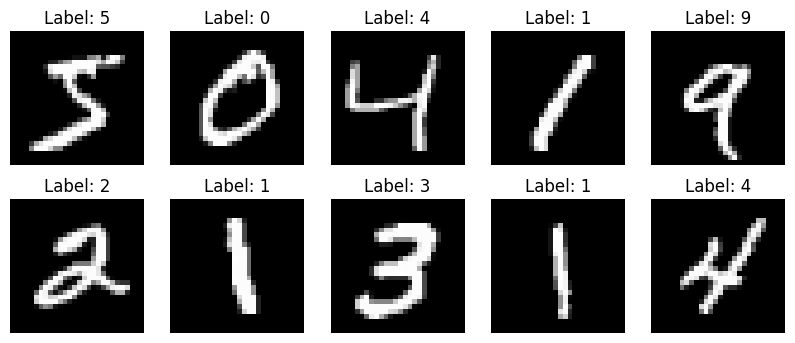

In [3]:
# Visualize the images
mnist_train = load_dataset("mnist", split="train")

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))

for i, ax in enumerate(axes.flatten()):
    image = mnist_train[i]["image"]
    label = mnist_train[i]["label"]
    image_array = np.array(image, dtype=np.float32)
    ax.imshow(image_array.squeeze(), cmap="gray")  # Squeeze the array if necessary
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.show()

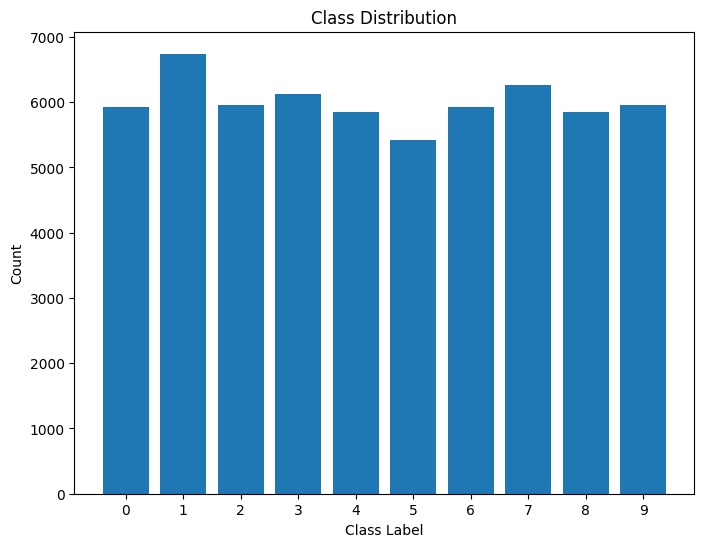

In [4]:
# Analyze the dataset

labels = mnist_train["label"]

# Calculate the class distribution
class_counts = np.bincount(labels)
class_labels = np.arange(10)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts)
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(class_labels)
plt.show()

In [12]:
# Preprocess dataset for image classification
mnist = load_dataset("mnist", split="train")
mnist = mnist.train_test_split(test_size=0.2)

labels = mnist["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label



Found cached dataset mnist (/Users/ankush/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)


In [31]:
# Define custom convnet configuration
class ConvnetConfig(PretrainedConfig):
    model_type = "convnet"

    def __init__(self, 
                 num_classes: int = 10,
                 dropout_rate: float = 0.2,
                 hidden_size: int = 128,
                 num_filters: int = 16,
                 kernel_size: int = 3,
                 stride: int = 1,
                 padding: int = 1,
                 pooling_size: int = 2,
                 **kwargs):
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.hidden_size = hidden_size
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.pooling_size = pooling_size
        super().__init__(**kwargs)


In [37]:
# Define custom convnet model for image classification
class ConvnetModelForImageClassification(PreTrainedModel):
    config_class = ConvnetConfig
    
    # Do some typing on config
    def __init__(self, config: ConvnetConfig):
        super().__init__(config)
        layers = [
            nn.Conv2d(1, 32, kernel_size=config.kernel_size, stride=config.stride, padding=config.padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=config.pooling_size),
            nn.Conv2d(32, 64, kernel_size=config.kernel_size, stride=config.stride, padding=config.padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=config.pooling_size),
            nn.Flatten(),
            nn.Linear(7*7*64,128),
            nn.ReLU(),
            nn.Linear(128,config.num_classes),    
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, inputs, labels=None):
        logits = self.model(inputs)
        if labels is not None:
            loss = torch.nn.CrossEntropyLoss(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

In [38]:
from transformers import ViTFeatureExtractor

# Setup dataset
mnist_dataset = load_dataset("mnist")


Found cached dataset mnist (/Users/ankush/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)


  0%|          | 0/2 [00:00<?, ?it/s]

In [39]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize config and model
convnet_mnist_config = ConvnetConfig()
convnet_mnist_model = ConvnetModelForImageClassification(convnet_mnist_config)
convnet_mnist_model.to(device)


# Create a training configuration
training_args = TrainingArguments(
    output_dir='./results',    # Directory to save checkpoints and results
    num_train_epochs=5,        # Number of training epochs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',      # Directory to save training logs
    logging_steps=100,
)

# Instantiate the Trainer
trainer = Trainer(
    model=convnet_mnist_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# Start training
trainer.train()

/Users/ankush/Library/Caches/pypoetry/virtualenvs/hf-models-JChwTGhx-py3.11/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/15625 [00:00<?, ?it/s]

TypeError: ConvnetModelForImageClassification.forward() missing 1 required positional argument: 'inputs'